# Classification (Logistic Regression, LDA, QDA)


Здравствуйте, на этом семинаре вы познакомитесь с задачей Классификации, Линейным и Квадратичным Дискриминантным Анализом (LDA & QDA), Логичестической регрессией, а так же познакомитесь с различными метрик классификации.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[Устройство ROC-curve и ROC AUC](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)\
[Построение многоклассового ROC-curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)\
[Построение PR-curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Задача 1


### Введение в LDA

Для начала научимся применять [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html), подключим его

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from math import log
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score



Сгенерируйте выборки $X_{0}\sim\mathcal{N}(\mu_{0},\Sigma_{0})$ объема $n_{0}=100$, где $\Sigma_{0}=\begin{pmatrix}2 & 0\\ 0 & 0.5\end{pmatrix}, \mu_{0}=(0,0)$ и $X_{1}\sim\mathcal{N}(\mu_{1},\Sigma_{1})$ объема $n_{1}=100$, где $\Sigma_{1}=\begin{pmatrix}0.5 & 0\\ 0 & 2\end{pmatrix}, \mu_{0}=(1,1)$, и изобразите их на плоскости. Попробуйте визуально разделить эти два класса

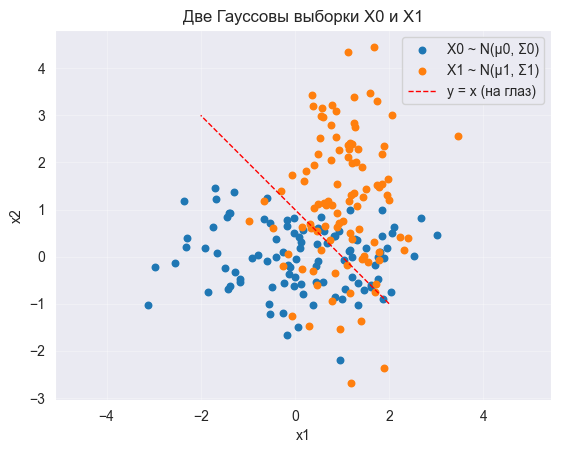

In [6]:

n0, n1 = 100, 100
mu0 = np.array([0.0, 0.0])
Sigma0 = np.array([[2.0, 0.0],
                   [0.0, 0.5]])

mu1 = np.array([1.0, 1.0])
Sigma1 = np.array([[0.5, 0.0],
                   [0.0, 2.0]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=n0)
X1 = np.random.multivariate_normal(mu1, Sigma1, size=n1)

fig = plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], s=22, label="X0 ~ N(μ0, Σ0)")
plt.scatter(X1[:, 0], X1[:, 1], s=22, label="X1 ~ N(μ1, Σ1)")

plt.plot([2, -2], [-1, 3], "--", lw=1, label="y = x (на глаз)", color="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Две Гауссовы выборки X0 и X1")
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Объедините выборки в единый набор данных и разделите их на два класса, добавив столбец label. Примените классификатор LDA к этим выборкам и оцените качество классификации

         x1        x2  label
0  1.210018  0.000462      0
1 -1.159944 -0.534521      0
2  1.176301  0.980802      0
3  1.461582 -0.713252      0
4  0.611091  0.545123      0
Test accuracy: 0.8166666666666667
Confusion matrix (rows=true, cols=pred):
 [[26  4]
 [ 7 23]]
Classification report:
               precision    recall  f1-score   support

           0      0.788     0.867     0.825        30
           1      0.852     0.767     0.807        30

    accuracy                          0.817        60
   macro avg      0.820     0.817     0.816        60
weighted avg      0.820     0.817     0.816        60

5-fold CV accuracy: 0.750 ± 0.057


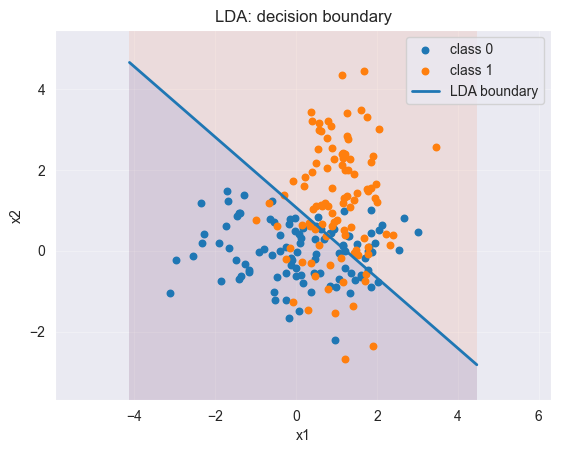

In [7]:

#clf = LinearDiscriminantAnalysis()
X = np.vstack([X0, X1])
y = np.concatenate([np.zeros(len(X0), dtype=int), np.ones(len(X1), dtype=int)])
df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'label': y})
print(df.head())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=52)

clf = LinearDiscriminantAnalysis() 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"5-fold CV accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

fig = plt.figure()

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 400),
                       np.linspace(x2_min, x2_max, 400))
grid = np.c_[xx1.ravel(), xx2.ravel()]
zz = clf.predict(grid).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, alpha=0.15, levels=[-0.5,0.5,1.5])

plt.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
plt.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')

w = clf.coef_[0]; b = clf.intercept_[0]
if abs(w[1]) > 1e-12:
    xs = np.linspace(x1_min, x1_max, 400)
    ys = -(w[0]*xs + b)/w[1]
    plt.plot(xs, ys, '-', lw=2, label='LDA boundary')

plt.xlabel('x1'); plt.ylabel('x2'); plt.title('LDA: decision boundary')
plt.legend(); plt.axis('equal'); plt.grid(alpha=0.3)
plt.show()

Так же, как и любая линейная модель, LDA строит разделяющую линейную поверхность вида $\overline{\omega}\overline{X}+b=0$ (для 2х классов). Данная поверхность соответствует стандартному порогу $t=\frac{1}{2}$. Подумайте, как меняется поверхность при выборе другого порога.


Изобразите построенную LDA поверхность вручную с помощью полей *.coef_* и *.intercept_* класса LinearDiscriminantAnalysis, а так же с помощью встроенных методов [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) или [plot_decision_region](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/)

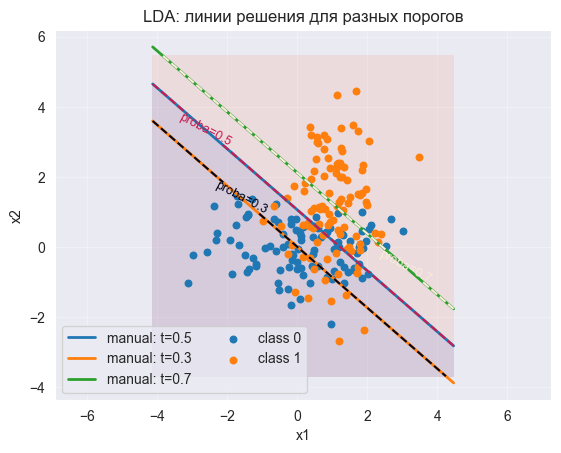

In [8]:
w = clf.coef_[0]
b = clf.intercept_[0]

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 800),
                       np.linspace(x2_min, x2_max, 800))
grid = np.c_[xx1.ravel(), xx2.ravel()]

fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", 
    plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
)


# Ручные прямые для разных порогов
def plot_line_for_t(ax, t, label):
    bt = b - log(t/(1-t))  # сдвиг intercept под произвольный порог
    if abs(w[1]) > 1e-12:
        xs = np.linspace(x1_min, x1_max, 400)
        ys = -(w[0]*xs + bt)/w[1]
        ax.plot(xs, ys, lw=2, label=label)
    else:
        x_vert = -bt / w[0]
        ax.axvline(x_vert, lw=2, label=label)

for t, lab in [(0.5, "manual: t=0.5"), (0.3, "manual: t=0.3"), (0.7, "manual: t=0.7")]:
    plot_line_for_t(ax, t, lab)
    
    
proba = clf.predict_proba(grid)[:, 1].reshape(xx1.shape)
cs = ax.contour(xx1, xx2, proba, levels=[0.3, 0.5, 0.7],
                linestyles=["--", "--", "--"], linewidths=1.5)
ax.clabel(cs, fmt=lambda v: f"proba={v:.1f}", inline=True, fontsize=9)

# 6) Точки
ax.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')

ax.set_xlabel('x1'); ax.set_ylabel('x2')
ax.set_title('LDA: линии решения для разных порогов')
ax.legend(ncol=2); ax.axis('equal'); ax.grid(alpha=0.3)
plt.show()



Используя обученные веса классификатора, постройте несколько разделяющих поверхностей при различных параметрах порога t

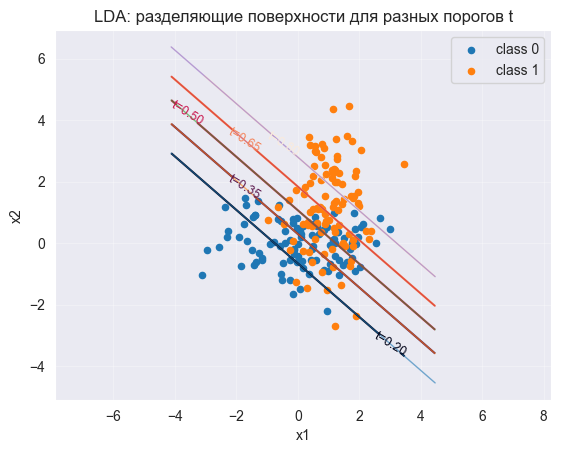

In [9]:
Ts = [0.2, 0.35, 0.5, 0.65, 0.8]
x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 800),
                       np.linspace(x2_min, x2_max, 800))
grid = np.c_[xx1.ravel(), xx2.ravel()]
proba = clf.predict_proba(grid)[:, 1].reshape(xx1.shape)

fig, ax = plt.subplots()

# Изолинии вероятности P(y=1|x)=t
cs = ax.contour(xx1, xx2, proba, levels=Ts, linewidths=1.5)
ax.clabel(cs, fmt=lambda v: f"t={v:.2f}", inline=True, fontsize=9)

# границы "вручную" (параллельные прямые): w^T x + b_t = 0
if abs(w[1]) > 1e-12:
    xs = np.linspace(x1_min, x1_max, 400)
    for t in Ts:
        bt = b - log(t/(1-t))
        ys = -(w[0]*xs + bt)/w[1]
        ax.plot(xs, ys, lw=1, alpha=0.6)
else:
    for t in Ts:
        bt = b - log(t/(1-t))
        x_vert = -bt / w[0]
        ax.axvline(x_vert, lw=1, alpha=0.6)

# Точки данных
ax.scatter(X[y==0,0], X[y==0,1], s=20, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=20, label='class 1')

ax.set_xlabel('x1'); ax.set_ylabel('x2')
ax.set_title('LDA: разделяющие поверхности для разных порогов t')
ax.legend(); ax.axis('equal'); ax.grid(alpha=0.3)
plt.show()

На сколько ваше предположение о виде прямой соответствует ответу LDA?

+- я попал)

### Метрики

Посчитайте вручную значение метрик [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (для порога $t=\dfrac{1}{2}$), а затем сравните со встроенными функциями sklearn

In [10]:
proba = clf.predict_proba(X_test)[:, 1]
y_pred05 = (proba >= 0.5).astype(int)
assert np.array_equal(y_pred, y_pred05), "y_pred не соответствует порогу 0.5"

# Подсчёт TP/TN/FP/FN вручную
tp = int(np.sum((y_test == 1) & (y_pred == 1)))
tn = int(np.sum((y_test == 0) & (y_pred == 0)))
fp = int(np.sum((y_test == 0) & (y_pred == 1)))
fn = int(np.sum((y_test == 1) & (y_pred == 0)))
n  = int(y_test.size)

acc = (tp + tn) / n
prec = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
rec  = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else float('nan')

print(f"Manual counts: TP={tp}, FP={fp}, TN={tn}, FN={fn}, N={n}")
print(f"Manual metrics (t=0.5): Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

# Сравнение со sklearn (binary, pos_label=1)
print("sklearn:",
      f"Acc={accuracy_score(y_test, y_pred):.3f}",
      f"P={precision_score(y_test, y_pred, zero_division=0):.3f}",
      f"R={recall_score(y_test, y_pred, zero_division=0):.3f}",
      f"F1={f1_score(y_test, y_pred, zero_division=0):.3f}")

Manual counts: TP=23, FP=4, TN=26, FN=7, N=60
Manual metrics (t=0.5): Accuracy=0.817  Precision=0.852  Recall=0.767  F1=0.807
sklearn: Acc=0.817 P=0.852 R=0.767 F1=0.807


Постройте [ROC-curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [PR-curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) и посчитайте [площади](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) под эти кривыми


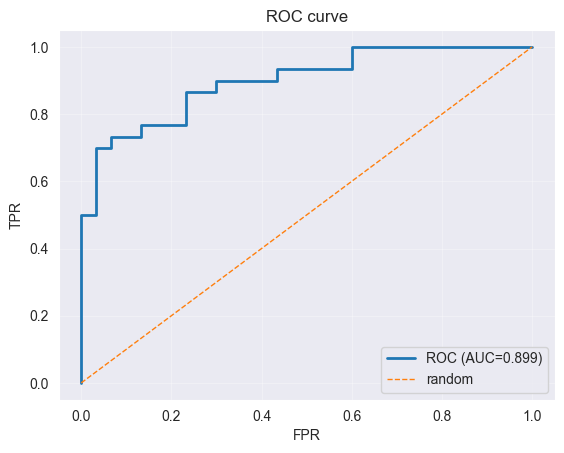

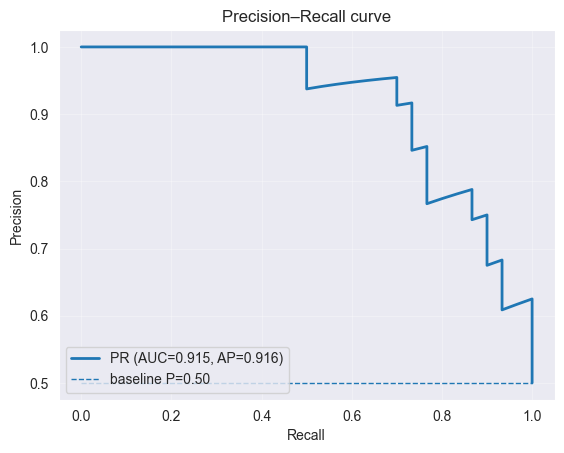

ROC AUC (auc) = 0.898889;  ROC AUC (roc_auc_score) = 0.898889
PR AUC (auc)   = 0.914574;  Average Precision (AP)   = 0.915890


In [11]:
y_score = clf.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, roc_th = roc_curve(y_test, y_score)  
roc_auc = auc(fpr, tpr)                        # ROC
roc_auc_chk = roc_auc_score(y_test, y_score)

# PR
prec, rec, pr_th = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)                        # площадь под PR-кривой (trapz)
ap = average_precision_score(y_test, y_score)  # Average Precision

prevalence = y_test.mean()                     # baseline for PR

fig = plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, label="random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

fig = plt.figure()
plt.plot(rec, prec, lw=2, label=f"PR (AUC={pr_auc:.3f}, AP={ap:.3f})")
plt.hlines(prevalence, 0, 1, linestyles="--", lw=1, label=f"baseline P={prevalence:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall curve"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

print(f"ROC AUC (auc) = {roc_auc:.6f};  ROC AUC (roc_auc_score) = {roc_auc_chk:.6f}")
print(f"PR AUC (auc)   = {pr_auc:.6f};  Average Precision (AP)   = {ap:.6f}")

Что вы можете сказать о качестве классификации модели LDA?

Визульно неплохо, но наверное можно было сделанть более качественную классификацию, используя кривые

## Задача 2

Теперь научимся применять [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


Примените QDA к данным из первой задачи, оцените качество модели, сравните с LDA

QDA test accuracy: 0.767
QDA confusion (rows=true, cols=pred):
 [[25  5]
 [ 9 21]]
QDA classification report:
               precision    recall  f1-score   support

           0      0.735     0.833     0.781        30
           1      0.808     0.700     0.750        30

    accuracy                          0.767        60
   macro avg      0.771     0.767     0.766        60
weighted avg      0.771     0.767     0.766        60

QDA 5-fold CV accuracy: 0.790 ± 0.070

Сравнение LDA vs QDA (accuracy):
model  test_acc  cv_acc_mean  cv_acc_std
  LDA  0.816667         0.75    0.057009
  QDA  0.766667         0.79    0.070000


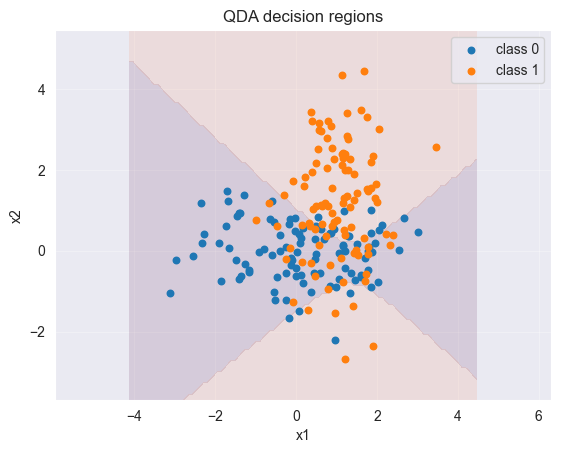

In [13]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)
acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"QDA test accuracy: {acc_qda:.3f}")
print("QDA confusion (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred_qda))
print("QDA classification report:\n", classification_report(y_test, y_pred_qda, digits=3)) 

# QDA cross-val (та же схема, что и для LDA)
cv_acc_qda = cross_val_score(qda, X, y, cv=cv, scoring='accuracy')
print(f"QDA 5-fold CV accuracy: {cv_acc_qda.mean():.3f} ± {cv_acc_qda.std():.3f}")

# Сравнение с LDA на тех же данных
acc_lda = accuracy_score(y_test, y_pred) 
cv_acc_lda = cross_val_score(clf, X, y, cv=cv, scoring='accuracy') 

cmp = pd.DataFrame({
    "model": ["LDA", "QDA"],
    "test_acc": [acc_lda, acc_qda],
    "cv_acc_mean": [cv_acc_lda.mean(), cv_acc_qda.mean()],
    "cv_acc_std":  [cv_acc_lda.std(),  cv_acc_qda.std()]
})
print("\nСравнение LDA vs QDA (accuracy):")
print(cmp.to_string(index=False))

# Для наглядности: фон QDA (контуры классов) + точки
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    qda, X, response_method="predict",
    plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
)
ax.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')
ax.set_title("QDA decision regions")
ax.set_xlabel("x1"); ax.set_ylabel("x2")
ax.legend(); ax.axis("equal"); ax.grid(alpha=0.3)
plt.show()

Сделайте дисбаланс классов в первой задаче $n_{0}=25,n_{1}=250$

Примените LDA и QDA. Постройте разделяющие поверхности.
Посчитайте метрики классификации и сравните две модели


LDA:
Accuracy=0.904  Precision=0.914  Recall=0.987  F1=0.949
Confusion (rows=true, cols=pred):
 [[ 1  7]
 [ 1 74]]

QDA:
Accuracy=0.916  Precision=0.915  Recall=1.000  F1=0.955
Confusion (rows=true, cols=pred):
 [[ 1  7]
 [ 0 75]]

Сравнение моделей (test metrics):
model  Accuracy  Precision   Recall       F1
  LDA  0.903614   0.913580 0.986667 0.948718
  QDA  0.915663   0.914634 1.000000 0.955414


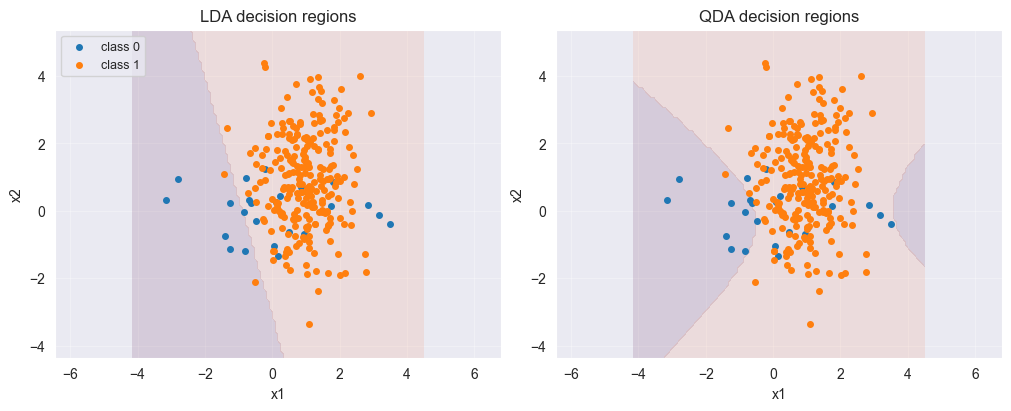

In [14]:
n0, n1 = 25, 250
mu0 = np.array([0.0, 0.0]); Sigma0 = np.array([[2.0, 0.0],[0.0, 0.5]])
mu1 = np.array([1.0, 1.0]); Sigma1 = np.array([[0.5, 0.0],[0.0, 2.0]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=n0)
X1 = np.random.multivariate_normal(mu1, Sigma1, size=n1)

X = np.vstack([X0, X1])
y = np.concatenate([np.zeros(len(X0), dtype=int), np.ones(len(X1), dtype=int)])

# Train/test с сохранением дисбаланса
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=52
)

# Модели
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

def eval_model(model, name):
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    cm   = confusion_matrix(y_test, y_pred)
    print(f"\n{name}:")
    print(f"Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")
    print("Confusion (rows=true, cols=pred):\n", cm)
    return {"model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# Оценка
rows = []
rows.append(eval_model(lda, "LDA"))
rows.append(eval_model(qda, "QDA"))

print("\nСравнение моделей (test metrics):")
print(pd.DataFrame(rows).to_string(index=False))

# Разделяющие поверхности
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
titles = ["LDA decision regions", "QDA decision regions"]
models = [lda, qda]

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1

for ax, mdl, ttl in zip(axes, models, titles):
    DecisionBoundaryDisplay.from_estimator(
        mdl, X, response_method="predict",
        plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
    )
    ax.scatter(X[y==0,0], X[y==0,1], s=16, label='class 0')
    ax.scatter(X[y==1,0], X[y==1,1], s=16, label='class 1')
    ax.set_title(ttl); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.axis("equal"); ax.grid(alpha=0.3)

axes[0].legend(loc="upper left", fontsize=9)
plt.show()

Какие метрики оказались информативными?

Accuracy как всегда максимально быстро даёт оценку. В остальном метрики слишком близки на глаз, чтобы говорить о том, что какая-то из них более информативна. Однако графическое распределение достаточно неплохо показывает, что в данном случае QDA справился лучше. На это также намекает то, что QDA лучше по каждой из метрик, но букавльно чуть-чуть

In [ ]:
#Your code here

Сравните визуально ROC-curve и PR-curve этих классификаторов. На PR-curve отметьте точку с наилучшей F1 мерой.

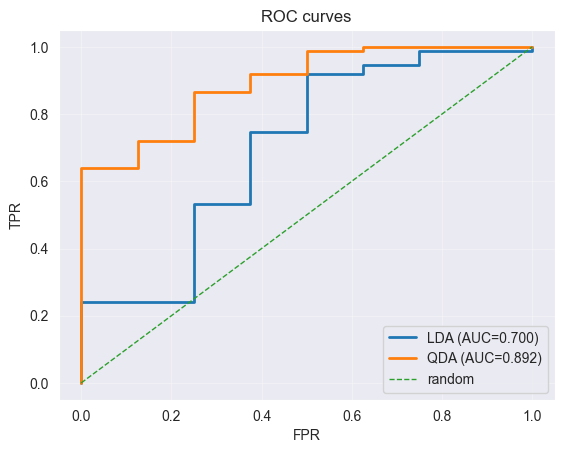

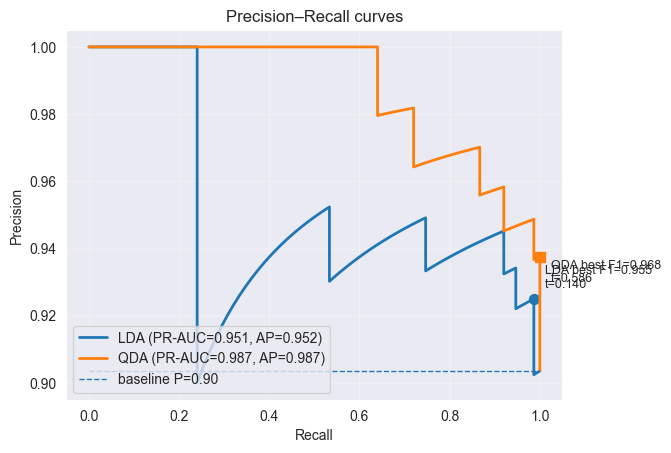

LDA:  ROC-AUC=0.7000  PR-AUC=0.9510  AP=0.9516  bestF1=0.9548 at t=0.140
QDA:  ROC-AUC=0.8917  PR-AUC=0.9870  AP=0.9871  bestF1=0.9677 at t=0.586


In [16]:
y_score_lda = clf.predict_proba(X_test)[:, 1] 
y_score_qda = qda.predict_proba(X_test)[:, 1]

def curves_and_best_f1(y_true, y_score):
    # ROC
    fpr, tpr, thr_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # PR
    prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
    pr_auc = auc(rec, prec)
    ap = average_precision_score(y_true, y_score)

    # Лучшая F1 на PR (по всем точкам кривой)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i_best = int(np.nanargmax(f1s))
    # соответствующий порог: для точки i>0 берём thr_pr[i-1], для i=0 порог формально > max(score)
    t_best = (thr_pr[i_best-1] if i_best > 0 else 1.1)


    return {
        "roc": (fpr, tpr, roc_auc),
        "pr": (rec, prec, pr_auc, ap),
        "best": {"idx": i_best, "rec": rec[i_best], "prec": prec[i_best], "f1": f1s[i_best], "thr": t_best}
    }

lda_stats = curves_and_best_f1(y_test, y_score_lda)
qda_stats = curves_and_best_f1(y_test, y_score_qda)

# ROC: both models
fig = plt.figure()
plt.plot(lda_stats["roc"][0], lda_stats["roc"][1], lw=2, label=f"LDA (AUC={lda_stats['roc'][2]:.3f})")
plt.plot(qda_stats["roc"][0], qda_stats["roc"][1], lw=2, label=f"QDA (AUC={qda_stats['roc'][2]:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, label="random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# PR: both models + top-F1
fig = plt.figure()
plt.plot(lda_stats["pr"][0], lda_stats["pr"][1], lw=2,
         label=f"LDA (PR-AUC={lda_stats['pr'][2]:.3f}, AP={lda_stats['pr'][3]:.3f})")
plt.plot(qda_stats["pr"][0], qda_stats["pr"][1], lw=2,
         label=f"QDA (PR-AUC={qda_stats['pr'][2]:.3f}, AP={qda_stats['pr'][3]:.3f})")

# top-F1
bL = lda_stats["best"]; bQ = qda_stats["best"]
plt.scatter([bL["rec"]], [bL["prec"]], s=50, marker="o")
plt.scatter([bQ["rec"]], [bQ["prec"]], s=50, marker="s")
plt.annotate(f"LDA best F1={bL['f1']:.3f}\nt={bL['thr']:.3f}",
             (bL["rec"], bL["prec"]), textcoords="offset points", xytext=(8,8), fontsize=9)
plt.annotate(f"QDA best F1={bQ['f1']:.3f}\nt={bQ['thr']:.3f}",
             (bQ["rec"], bQ["prec"]), textcoords="offset points", xytext=(8,-18), fontsize=9)

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles="--", lw=1, label=f"baseline P={baseline:.2f}")

plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall curves")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

print(f"LDA:  ROC-AUC={lda_stats['roc'][2]:.4f}  PR-AUC={lda_stats['pr'][2]:.4f}  AP={lda_stats['pr'][3]:.4f}  bestF1={bL['f1']:.4f} at t={bL['thr']:.3f}")
print(f"QDA:  ROC-AUC={qda_stats['roc'][2]:.4f}  PR-AUC={qda_stats['pr'][2]:.4f}  AP={qda_stats['pr'][3]:.4f}  bestF1={bQ['f1']:.4f} at t={bQ['thr']:.3f}")

Посчитайте и сравните ROC AUC и PR AUC для LDA и QDA.

In [17]:
y_score_lda = clf.predict_proba(X_test)[:, 1]
y_score_qda = qda.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc_lda = roc_auc_score(y_test, y_score_lda)
roc_auc_qda = roc_auc_score(y_test, y_score_qda)

# PR AUC and AP 
prec_l, rec_l, _ = precision_recall_curve(y_test, y_score_lda)
prec_q, rec_q, _ = precision_recall_curve(y_test, y_score_qda)

pr_auc_lda = auc(rec_l, prec_l)
pr_auc_qda = auc(rec_q, prec_q)

ap_lda = average_precision_score(y_test, y_score_lda)
ap_qda  = average_precision_score(y_test, y_score_qda)

print(f"LDA: ROC AUC = {roc_auc_lda:.4f} | PR AUC = {pr_auc_lda:.4f} | AP = {ap_lda:.4f}")
print(f"QDA: ROC AUC = {roc_auc_qda:.4f} | PR AUC = {pr_auc_qda:.4f} | AP = {ap_qda:.4f}")

res = pd.DataFrame({
    "model": ["LDA","QDA"],
    "ROC AUC": [roc_auc_lda, roc_auc_qda],
    "PR AUC": [pr_auc_lda, pr_auc_qda],
    "AP": [ap_lda, ap_qda]
})
print("\nСравнение на тесте:")
print(res.to_string(index=False))


print(f"\nΔ(ROC AUC) QDA-LDA = {roc_auc_qda - roc_auc_lda:+.4f}")
print(f"Δ(PR  AUC) QDA-LDA = {pr_auc_qda - pr_auc_lda:+.4f}")

LDA: ROC AUC = 0.7000 | PR AUC = 0.9510 | AP = 0.9516
QDA: ROC AUC = 0.8917 | PR AUC = 0.9870 | AP = 0.9871

Сравнение на тесте:
model  ROC AUC   PR AUC       AP
  LDA 0.700000 0.950968 0.951561
  QDA 0.891667 0.987019 0.987118

Δ(ROC AUC) QDA-LDA = +0.1917
Δ(PR  AUC) QDA-LDA = +0.0361


Какой из классификаторов справился лучше? Подумайте, почему так

QDA справильнось на покадок лучше, тк у LDA банально нет возможности забрать хвосты распределения, выходящего из облака с двух сторон. У QDA же такая возможность есть и это видно, что на кривых, когда QDA-ROC расстёт сильно быстрее, так и на PR-кривой, когда QDA падает сильно медленнее. Опять же это логично, тк для PR видит, что QDA ловит правильную классификацию в больших объёмах, а ROC гласит, что у QDA ошибок поменьше, а LDA вообще в моементе может быть похоже на случайный выбор(Да, в одной точке, но всё же)

## Задача 3

Для начала давайте познакомимся с [логистической регрессией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), подключим её из библиотеки

In [43]:
from sklearn.linear_model import LogisticRegression

Теперь сгенерируем два нормальных распределения и попробуем разделить их

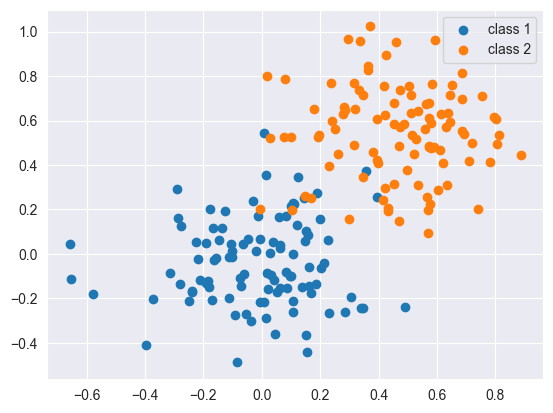

In [41]:
df = pd.DataFrame()
X1 = np.random.normal(0, 0.2, (100, 2))
X2 = np.random.normal(0.5, 0.2, (100, 2))
df["x"] = np.hstack([X1[:, 0], X2[:, 0]])
df["y"] = np.hstack([X1[:, 1], X2[:, 1]])
df["label"] = np.hstack([np.zeros(100), np.ones(100)])
plt.scatter(df[df["label"] == 0]["x"], df[df["label"] == 0]["y"], label="class 1")
plt.scatter(df[df["label"] == 1]["x"], df[df["label"] == 1]["y"], label="class 2")
plt.legend()
plt.show()

Создадим классификатор,обучим его и посмотрим на качество классификации

In [45]:
log_reg = LogisticRegression()
log_reg.fit(df[['x', 'y']], df['label'])
print("accuracy:", log_reg.score(df[['x', 'y']], df['label']))

accuracy: 0.955


Как и LDA, логистическая регрессия строит рязделяющую прямую, её коэффициенты можно получить из модели с помощью полей *.coef_* и *.intercept_*

Теперь постройте на исходных данных разделяющую прямую

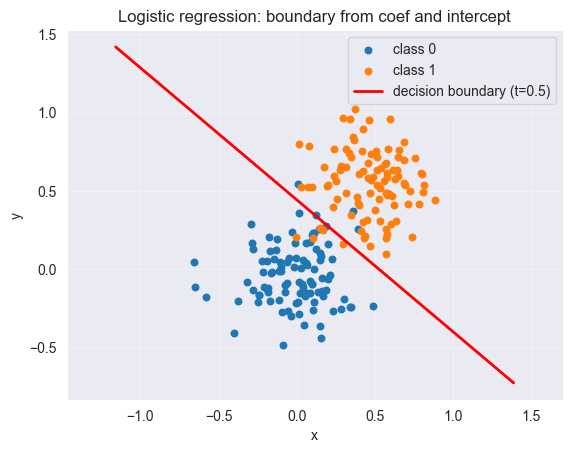

In [47]:
w1, w2 = log_reg.coef_[0]
b = float(log_reg.intercept_[0])

x_min, x_max = df["x"].min() - 0.5, df["x"].max() + 0.5
xs = np.linspace(x_min, x_max, 400)

plt.figure()
plt.scatter(df[df["label"] == 0]["x"], df[df["label"] == 0]["y"], label="class 0", s=22)
plt.scatter(df[df["label"] == 1]["x"], df[df["label"] == 1]["y"], label="class 1", s=22)

if abs(w2) > 1e-12:
    ys = -(w1*xs + b) / w2
    plt.plot(xs, ys, "r-", lw=2, label="decision boundary (t=0.5)")
else:
    x_vert = -b / w1
    plt.axvline(x_vert, color="r", lw=2, label="decision boundary (t=0.5)")

plt.xlabel("x"); plt.ylabel("y"); plt.title("Logistic regression: boundary from coef and intercept")
plt.legend(); plt.axis("equal"); plt.grid(alpha=0.3)
plt.show()

Аналогично линейной, логистическая регрессия может использовать регуляризацию при построении разделяющей прямой, за это отвечает параметр *penalty*, величину штрафа регулирует параметр *С*. Подробнее об этом можно посмотреть в [документаци](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Используйте L1, L2 и ElasticNet регуляризацию, попробуйте разные значения параметра *C*, изобразите на одном рисунке исходные данные и все четыре разделющие прямые: с и без регуляризации

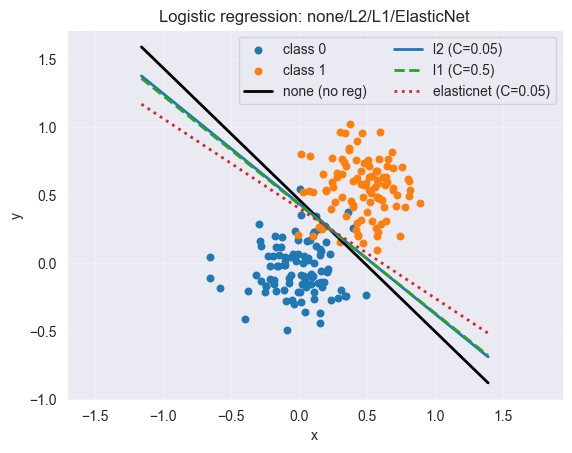

   penalty    C  accuracy
      none  NaN     0.955
        l2 0.05     0.955
        l1 0.50     0.955
elasticnet 0.05     0.955


In [49]:
X = df[['x','y']].to_numpy()
y = df['label'].to_numpy().astype(int)

# C-кандидаты для подбора
Cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

# Набор моделей: без регуляризации, L2, L1, ElasticNet (нужен solver='saga' и l1_ratio)
specs = [
    ("none",       {"penalty": None,          "solver": "lbfgs"}),   # без регуляризации
    ("l2",         {"penalty": "l2",          "solver": "lbfgs"}),   # L2: lbfgs ок
    ("l1",         {"penalty": "l1",          "solver": "saga"}),    # L1: нужен saga
    ("elasticnet", {"penalty": "elasticnet",  "solver": "saga", "l1_ratio": 0.5}),  # EN: saga + l1_ratio
]


results = []
for name, base in specs:
    if base["penalty"] is None:  # тут C не используется
        clf = LogisticRegression(max_iter=5000, random_state=52, **base)
        clf.fit(X, y)
        acc = clf.score(X, y)
        results.append({"name": name, "C": np.nan, "acc": acc, "clf": clf})
    else:
        best = None
        for C in Cs:
            clf = LogisticRegression(C=C, max_iter=5000, random_state=52, **base)
            clf.fit(X, y)
            acc = clf.score(X, y)
            if best is None or acc > best["acc"] or (np.isclose(acc, best["acc"]) and C < best["C"]):
                best = {"C": C, "acc": acc, "clf": clf}
        best["name"] = name
        results.append(best)

# График: точки + прямые решений из coef_/intercept_
colors = {"none": "k", "l2": "tab:blue", "l1": "tab:green", "elasticnet": "tab:red"}
styles  = {"none": "-",  "l2": "-",        "l1": "--",        "elasticnet": ":"}

x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
xs = np.linspace(x_min, x_max, 400)

plt.figure()
plt.scatter(df[df["label"] == 0]["x"], df[df["label"] == 0]["y"], s=22, label="class 0")
plt.scatter(df[df["label"] == 1]["x"], df[df["label"] == 1]["y"], s=22, label="class 1")

for r in results:
    clf = r["clf"]
    w1, w2 = clf.coef_[0]
    b = float(clf.intercept_[0])

    if abs(w2) > 1e-12:
        ys = -(w1*xs + b) / w2
        lbl = f"{r['name']}" + (f" (C={r['C']})" if np.isfinite(r['C']) else " (no reg)")
        plt.plot(xs, ys, linestyle=styles[r["name"]], color=colors[r["name"]], lw=2, label=lbl)
    else:
        x_vert = -b / w1
        lbl = f"{r['name']}" + (f" (C={r['C']})" if np.isfinite(r['C']) else " (no reg)")
        plt.axvline(x_vert, linestyle=styles[r["name"]], color=colors[r["name"]], lw=2, label=lbl)

plt.xlabel("x"); plt.ylabel("y"); plt.title("Logistic regression: none/L2/L1/ElasticNet")
plt.legend(ncol=2); plt.axis("equal"); plt.grid(alpha=0.3)
plt.show()

# Краткая сводка по выбранным C и точности (in-sample, как в вашем примере)
print(pd.DataFrame([{"penalty": r["name"], "C": r["C"], "accuracy": r["acc"]} for r in results]).to_string(index=False))

В каком случае получается наилучшее разделение?

+- одинаково потому что кучи достаточно разнесены сами по себе и разделить их не так сложно

### Сравнение Логистической регрессии, LDA и QDA

Смоделируйте для двух классов размера 100 из распределений в $\mathbb{R}^2$: $(X_i, Y_i)$, $X_i ∼ 𝑅[−1, 1]$, $Y_i = X_i + Z_i$, где $Z_i ∼ Laplace(-1, 0.5)$ для первого класса и $Z_i ∼ Laplace(1, 0.5)$ для второго

          x         y  label
0 -0.584175  0.184052      0
1  0.375743 -0.321324      0
2 -0.172114 -0.977901      0
3  0.747231 -0.307628      0
4  0.706636 -0.511888      0


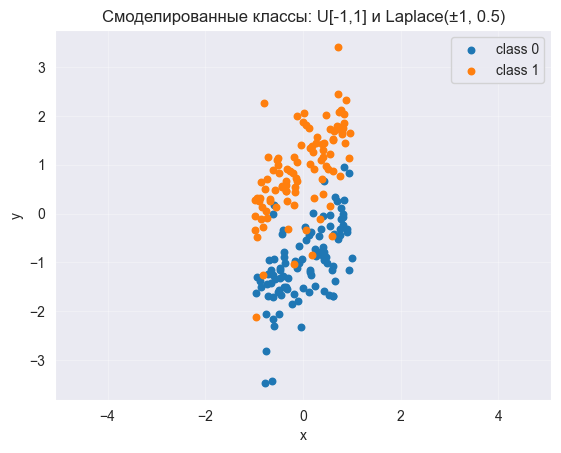

In [82]:
n = 100

X0 = np.random.uniform(-1, 1, size=n)
Z0 = np.random.laplace(loc=-1.0, scale=0.5, size=n)
Y0 = X0 + Z0

X1 = np.random.uniform(-1, 1, size=n)
Z1 = np.random.laplace(loc=+1.0, scale=0.5, size=n)
Y1 = X1 + Z1

df = pd.DataFrame({
    "x": np.hstack([X0, X1]),
    "y": np.hstack([Y0, Y1]),
    "label": np.hstack([np.zeros(n, dtype=int), np.ones(n, dtype=int)])
})

print(df.head())

plt.figure()
plt.scatter(df[df["label"]==0]["x"], df[df["label"]==0]["y"], s=22, label="class 0")
plt.scatter(df[df["label"]==1]["x"], df[df["label"]==1]["y"], s=22, label="class 1")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Смоделированные классы: U[-1,1] и Laplace(±1, 0.5)")
plt.legend(); plt.axis("equal"); plt.grid(alpha=0.3)
plt.show()

Запустите [логистический классификатор](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) и [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)


Logistic
Accuracy=0.917  Precision=0.931  Recall=0.900  F1=0.915
Confusion (rows=true, cols=pred):
 [[28  2]
 [ 3 27]]
              precision    recall  f1-score   support

           0      0.903     0.933     0.918        30
           1      0.931     0.900     0.915        30

    accuracy                          0.917        60
   macro avg      0.917     0.917     0.917        60
weighted avg      0.917     0.917     0.917        60


LDA
Accuracy=0.917  Precision=0.931  Recall=0.900  F1=0.915
Confusion (rows=true, cols=pred):
 [[28  2]
 [ 3 27]]
              precision    recall  f1-score   support

           0      0.903     0.933     0.918        30
           1      0.931     0.900     0.915        30

    accuracy                          0.917        60
   macro avg      0.917     0.917     0.917        60
weighted avg      0.917     0.917     0.917        60


QDA
Accuracy=0.917  Precision=0.931  Recall=0.900  F1=0.915
Confusion (rows=true, cols=pred):
 [[28  2]
 [ 3 2

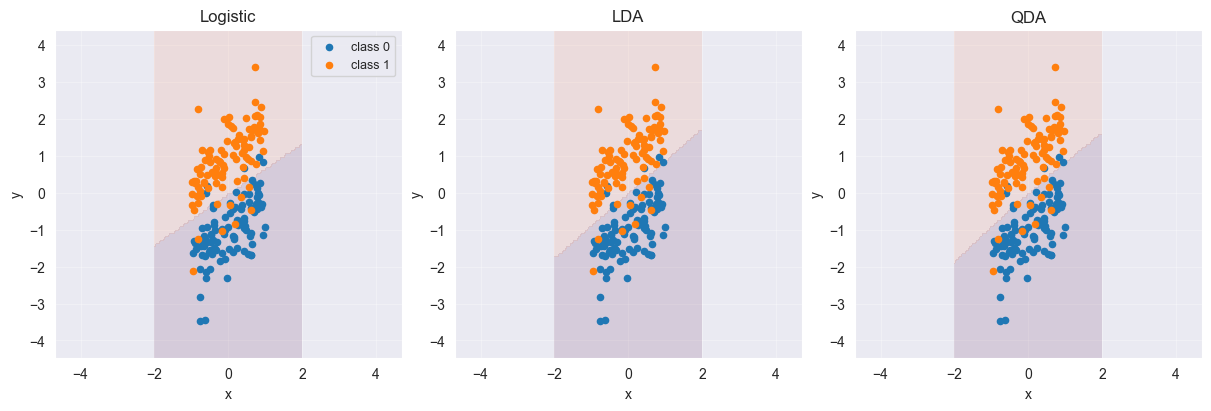

In [83]:
X = df[['x','y']].to_numpy()
y = df['label'].to_numpy().astype(int)

# Разбиение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=52
)

# Модели
models = {
    "Logistic": LogisticRegression(max_iter=5000, solver="lbfgs", random_state=52),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis()
}

results = []
for name, mdl in models.items():
    try:
        mdl.fit(X_train, y_train)
    except Exception as e:
        # редкая страховка для QDA при плохой ковариации
        if name == "QDA":
            mdl = QuadraticDiscriminantAnalysis(reg_param=0.1)
            mdl.fit(X_train, y_train)
            models[name] = mdl
        else:
            raise e
    y_pred = mdl.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    cm   = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print(f"Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")
    print("Confusion (rows=true, cols=pred):\n", cm)
    print(classification_report(y_test, y_pred, digits=3))
    results.append({"model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

print("\nСводка:")
print(pd.DataFrame(results).sort_values("Accuracy", ascending=False).to_string(index=False))

# Разделяющие поверхности (на всех данных для наглядности)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5

for ax, (name, mdl) in zip(axes, models.items()):
    DecisionBoundaryDisplay.from_estimator(
        mdl, X, response_method="predict",
        plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
    )
    ax.scatter(X[y==0,0], X[y==0,1], s=20, label='class 0')
    ax.scatter(X[y==1,0], X[y==1,1], s=20, label='class 1')
    ax.set_title(name)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_xlim(x1_min, x1_max); ax.set_ylim(x2_min, x2_max)
    ax.axis("equal"); ax.grid(alpha=0.3)

axes[0].legend(loc="best", fontsize=9)
plt.show()

Изобразите три [ROC–кривые](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и три [PR–кривые](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

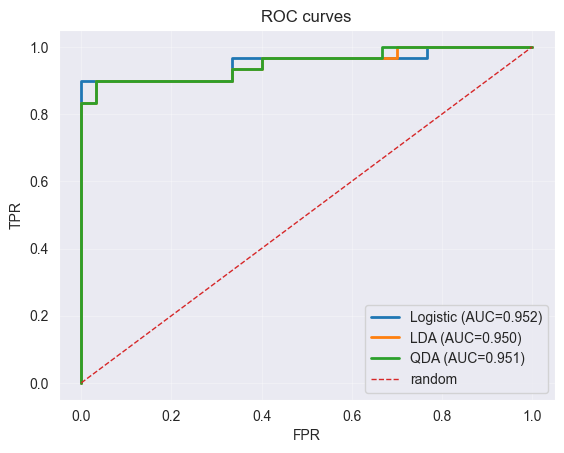

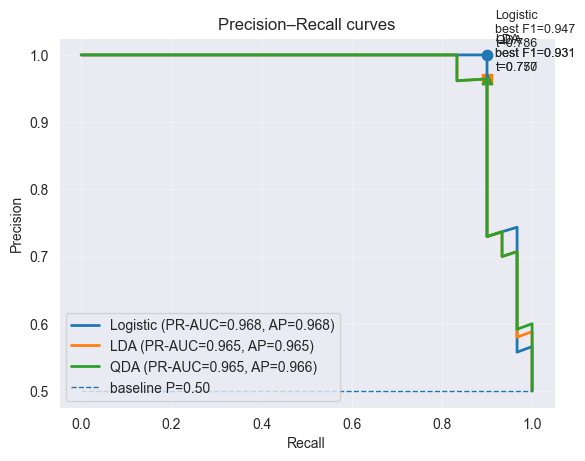

Logistic: ROC-AUC=0.9522  PR-AUC=0.9678  AP=0.9682  bestF1=0.9474 at t=0.786
LDA: ROC-AUC=0.9500  PR-AUC=0.9649  AP=0.9653  bestF1=0.9310 at t=0.750
QDA: ROC-AUC=0.9511  PR-AUC=0.9653  AP=0.9657  bestF1=0.9310 at t=0.777


In [84]:
clfs = {"Logistic": models["Logistic"], "LDA": models["LDA"], "QDA": models["QDA"]}

def curves_stats(y_true, clf, X):
    y_score = clf.predict_proba(X)[:, 1]
    # ROC
    fpr, tpr, thr_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # PR
    prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
    pr_auc = auc(rec, prec)
    ap = average_precision_score(y_true, y_score)
    # лучшая F1 точка на PR
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i_best = int(np.nanargmax(f1s))
    t_best = (thr_pr[i_best-1] if i_best > 0 else 1.1)
    return {"score": y_score, "roc": (fpr, tpr, roc_auc),
            "pr": (rec, prec, pr_auc, ap), "best": (rec[i_best], prec[i_best], f1s[i_best], t_best)}

stats = {name: curves_stats(y_test, clf, X_test) for name, clf in clfs.items()}

# ROC
fig = plt.figure()
for name, s in stats.items():
    fpr, tpr, roc_auc = s["roc"]
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, label="random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# PR + отметки лучших F1
fig = plt.figure()
baseline = y_test.mean()
markers = {"Logistic":"o", "LDA":"s", "QDA":"^"}
for name, s in stats.items():
    rec, prec, pr_auc, ap = s["pr"]
    rb, pb, f1b, tb = s["best"]
    plt.plot(rec, prec, lw=2, label=f"{name} (PR-AUC={pr_auc:.3f}, AP={ap:.3f})")
    plt.scatter([rb], [pb], s=55, marker=markers[name])
    plt.annotate(f"{name}\nbest F1={f1b:.3f}\nt={tb:.3f}",
                 (rb, pb), textcoords="offset points", xytext=(6,6), fontsize=9)
plt.hlines(baseline, 0, 1, linestyles="--", lw=1, label=f"baseline P={baseline:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall curves"); plt.legend(); plt.grid(alpha=0.3)
plt.show()


for name, s in stats.items():
    print(f"{name}: ROC-AUC={s['roc'][2]:.4f}  PR-AUC={s['pr'][2]:.4f}  AP={s['pr'][3]:.4f}  bestF1={s['best'][2]:.4f} at t={s['best'][3]:.3f}")

Выберите значения 𝑡 для каждого из трех классификаторов, оптимизируя [𝐹1–меру](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [85]:
def best_f1_threshold(y_true, y_score):
    # precision_recall_curve возвращает precision/recall длиной N+1 и thresholds длиной N
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i_best = int(np.nanargmax(f1s))
    # если лучший индекс 0 (край слева), берём порог чуть ниже минимального
    if i_best == 0:
        t_best = (thr.min() - 1e-12) if thr.size else 0.5
    else:
        t_best = thr[i_best - 1]
    return float(t_best), float(f1s[i_best]), float(prec[i_best]), float(rec[i_best])

rows = []
for name, mdl in models.items():
    y_score = mdl.predict_proba(X_test)[:, 1]
    # лучший порог по F1
    t_best, f1b, pb, rb = best_f1_threshold(y_test, y_score)
    y_pred_best = (y_score >= t_best).astype(int)

    # метрики при лучшем пороге
    acc = accuracy_score(y_test, y_pred_best)
    prec = precision_score(y_test, y_pred_best, zero_division=0)
    rec  = recall_score(y_test, y_pred_best, zero_division=0)
    f1   = f1_score(y_test, y_pred_best, zero_division=0)
    cm   = confusion_matrix(y_test, y_pred_best)

    print(f"\n{name}: best F1 @ t={t_best:.4f}  ->  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  Acc={acc:.3f}")
    print("Confusion (rows=true, cols=pred):\n", cm)

    # для сравнения с дефолтным t=0.5
    y_pred05 = (y_score >= 0.5).astype(int)
    f1_05 = f1_score(y_test, y_pred05, zero_division=0)

    rows.append({
        "model": name, "t_best": t_best,
        "F1_best": f1, "Precision_best": prec, "Recall_best": rec, "Acc_best": acc,
        "F1_at_0.5": f1_05
    })

print("\nСводка по лучшим порогам (на тесте):")
print(pd.DataFrame(rows).sort_values("F1_best", ascending=False).to_string(index=False))


Logistic: best F1 @ t=0.7860  ->  Precision=0.964  Recall=0.900  F1=0.931  Acc=0.933
Confusion (rows=true, cols=pred):
 [[29  1]
 [ 3 27]]

LDA: best F1 @ t=0.7503  ->  Precision=0.931  Recall=0.900  F1=0.915  Acc=0.917
Confusion (rows=true, cols=pred):
 [[28  2]
 [ 3 27]]

QDA: best F1 @ t=0.7769  ->  Precision=0.931  Recall=0.900  F1=0.915  Acc=0.917
Confusion (rows=true, cols=pred):
 [[28  2]
 [ 3 27]]

Сводка по лучшим порогам (на тесте):
   model   t_best  F1_best  Precision_best  Recall_best  Acc_best  F1_at_0.5
Logistic 0.785961 0.931034        0.964286          0.9  0.933333   0.915254
     LDA 0.750343 0.915254        0.931034          0.9  0.916667   0.915254
     QDA 0.776918 0.915254        0.931034          0.9  0.916667   0.915254


Нарисуйте облака точек на плоскости и три разделяющие кривые

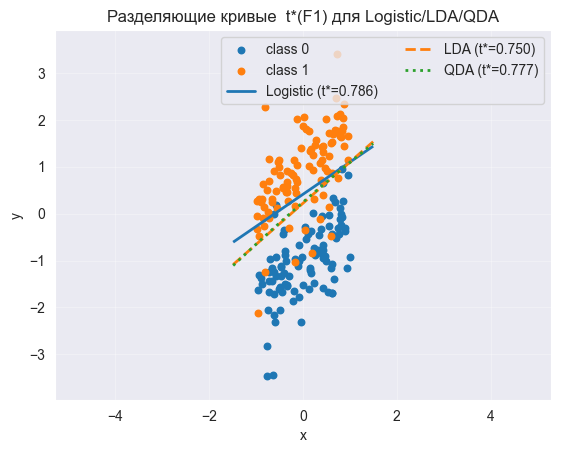

In [88]:
def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    i  = int(np.nanargmax(f1))
    t  = thr[i-1] if i > 0 else (thr.min() - 1e-12 if len(thr) else 0.5)
    return float(t)

# Порог t* для КАЖДОЙ модели
best_t_map = {}
for name, mdl in models.items():
    y_score = mdl.predict_proba(X_test)[:, 1]
    best_t_map[name] = best_f1_threshold(y_test, y_score)

X_plot = df[["x","y"]].to_numpy()
pad = 0.5
x1_min, x1_max = X_plot[:,0].min()-pad, X_plot[:,0].max()+pad
x2_min, x2_max = X_plot[:,1].min()-pad, X_plot[:,1].max()+pad
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 800),
                     np.linspace(x2_min, x2_max, 800))
grid = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots()
ax.scatter(df.loc[df.label==0,"x"], df.loc[df.label==0,"y"], s=22, label="class 0")
ax.scatter(df.loc[df.label==1,"x"], df.loc[df.label==1,"y"], s=22, label="class 1")

# стили для линий
styles = {
    "Logistic": dict(color="tab:blue",  linestyle="-"),
    "LDA":      dict(color="tab:orange",linestyle="--"),
    "QDA":      dict(color="tab:green", linestyle=":"),
}

# Контуры prob = t*
line_handles = []
for name, mdl in models.items():
    prob = mdl.predict_proba(grid)[:, 1].reshape(xx.shape)
    t = best_t_map[name]
    pmin, pmax = float(np.nanmin(prob)), float(np.nanmax(prob))
    if not (pmin <= t <= pmax):
        print(f"{name}: t={t:.3f} вне [{pmin:.3f},{pmax:.3f}] — контур пропущен")
        continue
    style = styles.get(name, {})
    kw2 = {}
    if "color" in style:
        kw2["colors"] = [style["color"]]
    if "linestyle" in style:
        kw2["linestyles"] = [style["linestyle"]]
    ax.contour(xx, yy, prob, levels=[t], linewidths=[2], **kw2)
    # прокси-линия для легенды
    line_handles.append(plt.Line2D([], [], linewidth=2, label=f"{name} (t*={t:.3f})", color=style.get("color", None),linestyle=style.get("linestyle", None)))

pt_handles, pt_labels = ax.get_legend_handles_labels()
ax.legend(pt_handles + line_handles, pt_labels + [h.get_label() for h in line_handles],
          ncol=2, loc="best")

ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Разделяющие кривые  t*(F1) для Logistic/LDA/QDA")
ax.axis("equal"); ax.grid(alpha=0.3)
plt.show()

Какой из классификаторов справился лучше и почему?

Да как-то не видно разницы особо, тк разделение очевидное. По цифрам Log-reg справилась лучше, но лишь немного, в остальном же разделение и правда слишком простое, чтобы какая-то из моделей показала своё явное превосходство, а данных не так много, чтобы был смысл оценивать время, затраченное на классификацию

## Задача 4

Загрузите данные из файла mroz.txt (описания переменных приведены в файле mroz.des)

Ваша задача — определить по данным женщины, работает ли она или нет (переменная inlf, равная $1$, если работает).

`Не используйте` переменные hours (количество рабочих часов — переменная равна нулю для неработающих), wage (заработок женщины), repwage (ответ на вопрос о величине дохода женщины) и lwage (логарифм переменной wage).

Разбейте выборку на [train, validation и test sets](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Разные классификаторы сравнивайте на validation set. Классификатор, выбранный вами наилучшим, тестируйте на test set.

In [18]:
COLS = [
    "inlf","hours","kidslt6","kidsge6","age","educ","wage","repwage",
    "hushrs","husage","huseduc","huswage","faminc","mtr","motheduc",
    "fatheduc","unem","city","exper","nwifeinc","lwage","expersq"
]
ban = {"hours","wage","repwage","lwage", "faminc"} # Если не убирать faminc, то получаем wife_earn = faminc - 1000·nwifeinc = wage·hours в QDA и там будет 1.0. Также можно выкинуть nwifeinc, но результат получается хуже
target = "inlf"

df = pd.read_csv("data/MROZ.raw", sep=r"\s+", header=None, names=COLS, engine="python")
df = df.replace({".": np.nan})

X_cols = [c for c in df.columns if c != target and c not in ban]
df[target] = pd.to_numeric(df[target], errors="coerce")
df[X_cols] = df[X_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=[target] + X_cols)

X = df[X_cols].to_numpy()
y = df[target].to_numpy(dtype=int)

print("Class counts (full):", dict(zip(*np.unique(y, return_counts=True))))

# разбиение со стратификацией
X_trval, X_te, y_trval, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=52)
X_tr, X_val, y_tr, y_val = train_test_split(X_trval, y_trval, test_size=0.25, stratify=y_trval, random_state=52)
print("train:", dict(zip(*np.unique(y_tr,  return_counts=True))),
      "val:",   dict(zip(*np.unique(y_val, return_counts=True))),
      "test:",  dict(zip(*np.unique(y_te,  return_counts=True))))

print(f"Shapes: train={X_tr.shape}, val={X_val.shape}, test={X_te.shape}")
print("Class balance (train):", np.mean(y_tr))


models = {
    "LogReg_L2": Pipeline([
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000, random_state=52))
    ]),
    "LogReg_L1": Pipeline([
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(penalty="l1", solver="saga", max_iter=5000, random_state=52))
    ]),
    "SVC_RBF": Pipeline([
        ("sc", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=52))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2, random_state=52, n_jobs=-1
    ),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis()
}

# Функции метрик (на валидации берём F1 в качестве основного критерия)
def pr_auc_score(y_true, y_score):
    p, r, _ = precision_recall_curve(y_true, y_score)
    return auc(r, p)

def eval_on(Xa, ya, model):
    # стараемся взять вероятности; если нет, то decision_function
    if hasattr(model, "predict_proba"):
        s = model.predict_proba(Xa)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xa)
    else:
        # запасной вариант: предикт как скор (плохо для AUC, но можно попробовать)
        s = model.predict(Xa)
    yp = (s >= 0.5).astype(int)
    return {
        "acc": accuracy_score(ya, yp),
        "prec": precision_score(ya, yp, zero_division=0),
        "rec": recall_score(ya, yp, zero_division=0),
        "f1": f1_score(ya, yp, zero_division=0),
        "roc_auc": roc_auc_score(ya, s),
        "pr_auc": pr_auc_score(ya, s)
    }

# Обучение на train, выбор по validation
val_rows = []
fitted = {}
for name, mdl in models.items():
    try:
        mdl.fit(X_tr, y_tr)
    except Exception:
        # QDA иногда требует регуляризации
        if name == "QDA":
            mdl = QuadraticDiscriminantAnalysis(reg_param=0.1)
            mdl.fit(X_tr, y_tr)
            models[name] = mdl
        else:
            raise
    fitted[name] = mdl
    m = eval_on(X_val, y_val, mdl)
    val_rows.append({"model": name, **m})

val_tbl = pd.DataFrame(val_rows).sort_values(["f1","roc_auc","pr_auc"], ascending=False)
print("\nValidation metrics (sorted by F1):")
print(val_tbl.to_string(index=False))

best_name = val_tbl.iloc[0]["model"]
best_model = fitted[best_name]
print(f"\nChosen model (by validation F1): {best_name}")

# Финальная оценка на test
test_m = eval_on(X_te, y_te, best_model)
print("\nTest metrics for the chosen model:")
for k,v in test_m.items():
    print(f"{k:8s}: {v:.4f}")

# матрица ошибок и отчёт
if hasattr(best_model, "predict_proba"):
    y_score_te = best_model.predict_proba(X_te)[:,1]
else:
    y_score_te = getattr(best_model, "decision_function")(X_te)
y_pred_te = (y_score_te >= 0.5).astype(int)
cm = confusion_matrix(y_te, y_pred_te)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n", classification_report(y_te, y_pred_te, digits=3))

# 7) Чтобы потом можно было быстро посмотреть важности/коэффициенты:
if isinstance(best_model, Pipeline) and isinstance(best_model[-1], LogisticRegression):
    clf = best_model[-1]
    coef = clf.coef_.ravel()
    imp = pd.Series(coef, index=X_cols)
    print("\nTop coefficients (Logistic):")
    print(imp.sort_values(key=np.abs, ascending=False).head(12).to_string())
elif isinstance(best_model, RandomForestClassifier):
    imp = pd.Series(best_model.feature_importances_, index=X_cols)
    print("\nTop importances (RF):")
    print(imp.sort_values(ascending=False).head(12).to_string())

Class counts (full): {np.int64(0): np.int64(325), np.int64(1): np.int64(428)}
train: {np.int64(0): np.int64(195), np.int64(1): np.int64(256)} val: {np.int64(0): np.int64(65), np.int64(1): np.int64(86)} test: {np.int64(0): np.int64(65), np.int64(1): np.int64(86)}
Shapes: train=(451, 16), val=(151, 16), test=(151, 16)
Class balance (train): 0.5676274944567627

Validation metrics (sorted by F1):
       model      acc     prec      rec       f1  roc_auc   pr_auc
         LDA 0.761589 0.784091 0.802326 0.793103 0.826118 0.877228
         QDA 0.754967 0.775281 0.802326 0.788571 0.781574 0.824560
   LogReg_L1 0.735099 0.761364 0.779070 0.770115 0.828623 0.878202
   LogReg_L2 0.735099 0.761364 0.779070 0.770115 0.823792 0.874241
RandomForest 0.721854 0.739130 0.790698 0.764045 0.779428 0.838432
     SVC_RBF 0.715232 0.736264 0.779070 0.757062 0.767263 0.819631

Chosen model (by validation F1): LDA

Test metrics for the chosen model:
acc     : 0.7682
prec    : 0.7865
rec     : 0.8140
f1      : 

Занятный результат в том, что казалось бы сложная задача по определению занятости человека по косвенным параметрам лучше всего решается простейшей LDA. 